# Headline Category Classifier

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Load Data and Prepare Language Model

In [0]:
path = Path('data/mediabias')
path.ls()

[PosixPath('data/mediabias/data_lm.pkl'),
 PosixPath('data/mediabias/data_save.pkl'),
 PosixPath('data/mediabias/models'),
 PosixPath('data/mediabias/articles.csv'),
 PosixPath('data/mediabias/data_clas.pkl')]


(Can skip to loading language model if not first execution)

In [0]:
df = pd.read_csv(path/'articles.csv')
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [0]:
df['TITLE'][1]

"Fed's Charles Plosser sees high bar for change in pace of tapering"

In [0]:
data_lm = TextDataBunch.from_csv(path, 'articles.csv')

FileNotFoundError: [Errno 2] File b'data/mediabias/articles.csv' does not exist: b'data/mediabias/articles.csv'

Save Language Model (can skip preparing data after first execution.)

In [0]:
data_lm.save()

NameError: name 'data_lm' is not defined

Load Language Model (run this instead of preparing data after first execution)

In [0]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data = TextClasDataBunch.from_csv(path, 'articles.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
251834, 70030, 6967, 360916, 239842...
  if getattr(ds, 'warn', False): warn(ds.warn)


text,target
xxbos i never thought i 'd be in love ” says xxmaj angelina xxmaj jolie \t http : / / www.shanghaidaily.com / article / xxunk \ ? xxunk \t xxmaj shanghai xxmaj daily \ ( subscription \ ) \t e \t dsk9w1sx3_u4d4mgvroyrj - ccxxam \t www.shanghaidaily.com \t xxunk \n xxunk \t xxmaj angelina xxmaj jolie : i never thought i 'd be in love but xxmaj brad xxmaj pitt,195218
"xxbos xxmaj car xxmaj exec xxmaj loses xxmaj money xxmaj on xxmaj electric xxmaj cars , xxmaj says ' i xxmaj hope xxmaj you xxmaj do n't xxmaj buy xxmaj it ' [ xxup video ]",245979
"xxbos xxmaj kim xxup k. and xxmaj kanye xxmaj west xxmaj tie xxmaj the xxmaj knot , xxmaj and xxmaj more xxmaj of ' xxmaj what 's xxmaj trending xxmaj today ' xxmaj with ...",254104
"xxbos ' xxmaj game xxmaj of xxmaj thrones ' xxmaj star xxmaj kit xxmaj harington xxmaj talks xxmaj on - xxmaj screen xxmaj nudity xxmaj and xxmaj sex , xxmaj ahead xxmaj of ...",67253
"xxbos xxmaj weekend xxmaj box xxmaj office : ' 22 xxmaj jump xxmaj street ' xxmaj nabs $ 57 m , ' xxmaj how xxmaj to xxmaj train xxmaj your xxmaj dragon 2 ...",295441


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 "'"]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [0]:
data.train_ds[0][0]

Text xxbos xxmaj sweets makers do n't want their brand names on e - cigarettes

But the underlying data is all numbers

In [0]:
data.train_ds[0][0].data[:10]

array([    2,     5, 15307,  1945,   153,    60,   579,   272,  1333,  1058])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
data = (TextList.from_csv(path, 'articles.csv', cols='TITLE')
                .random_split_by_pct(0.2)
                .label_from_df(cols=4)
                .databunch())

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'articles.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'articles.csv', vocab=data_lm.train_ds.vocab, bs=48)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
348080, 137786, 357414, 295244, 13964...
  if getattr(ds, 'warn', False): warn(ds.warn)


## Language model

Note: language models can have a lot of GPU usage, so you may need to decrease batchsize here.

In [0]:
bs=48

Train Language Model on Training Dataset

In [0]:
path = path
path.ls()

[PosixPath('data/mediabias/data_lm.pkl'),
 PosixPath('data/mediabias/data_save.pkl'),
 PosixPath('data/mediabias/models'),
 PosixPath('data/mediabias/articles.csv'),
 PosixPath('data/mediabias/data_clas.pkl')]

In [0]:
(path/'train').ls()

Startingwith pre-trained [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset) model and specialize from there to reduce training times.

In [0]:
data_lm = (TextList.from_csv(path, 'articles.csv', cols='TITLE')
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

In [1]:
data_lm.save('data_lm.pkl')

NameError: ignored

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,: xxmaj nasty xxmaj weather xxmaj has xxmaj curbed xxmaj job xxmaj growth xxbos xxmaj plosser : xxmaj fed xxmaj may xxmaj have to xxmaj accelerate xxmaj tapering xxmaj pace xxbos xxmaj fed 's xxmaj plosser expects xxup us unemployment to fall to 6.2 % by the end of 2014 xxbos xxup us jobs growth last month hit by weather : xxmaj fed xxmaj president xxmaj charles xxmaj plosser xxbos
1,updated with xxmaj digital xxmaj tipping and “ xxmaj shake to xxmaj pay ” xxbos xxmaj starbucks xxmaj will xxmaj soon xxmaj let xxmaj you xxmaj tip xxmaj your xxmaj barista xxmaj from xxmaj your iphone xxbos xxmaj next up at xxmaj starbucks : digital tips xxbos xxmaj starbucks ' new iphone app could xxunk baristas ' wallets xxbos xxmaj starbucks xxmaj accelerates xxmaj mobile xxmaj payment xxmaj leadership with
2,"xxmaj retina ipad xxbos xxmaj apple 's 8 xxup gb iphone 5c : xxmaj deal or xxmaj no xxmaj deal ? xxbos xxmaj apple xxmaj quietly xxmaj pulls ipad 2 , xxmaj puts ipad 4 on xxmaj sale xxmaj again xxbos xxmaj apple ( xxup aapl ) xxmaj announces ipad with xxmaj retina xxmaj display ; xxmaj will xxmaj start at $ 399 xxbos 8 xxup gb iphone xxup 5c"
3,"t. rex , say scientists xxbos xxup video : xxmaj researchers xxmaj discover xxmaj giant xxmaj chicken - xxmaj like xxmaj dinosaur xxbos xxmaj scientists call new dinosaur a ' chicken from hell ' xxbos xxmaj weird ' chicken from hell ' dinosaur lived alongside xxup t. rex 66-million years ago xxbos xxmaj scientists discover new dinosaur species called ' chicken from hell ' xxbos xxmaj chicken from hell sheds"
4,"interest xxmaj rates at xxmaj chase xxmaj bank ( xxmaj march 20 , 2014 ) xxbos xxmaj mortgage xxmaj interest xxmaj rates at xxup td xxmaj bank are xxmaj holding xxmaj steady on xxmaj march 20 , 2014 xxbos xxmaj mortgage xxmaj interest xxmaj rates at xxup bb&t xxmaj moved to a xxmaj higher xxmaj level on xxmaj march 20 , 2014 xxbos xxmaj jumbo xxmaj mortgage xxmaj rates xxmaj"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


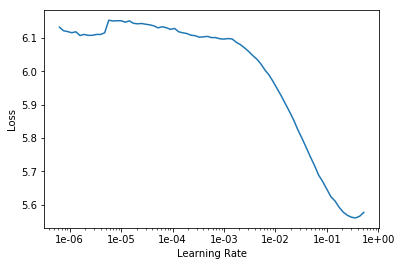

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 6e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.639791,4.405470,0.367713,07:43


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

Fine-tuning: unfeeze and launch new, finer training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.707446,3.615855,0.431866,09:10
1,3.435991,3.344393,0.453688,09:09
2,3.175666,3.124017,0.475791,09:09
3,2.944321,2.968702,0.494384,09:09
4,2.799997,2.934319,0.500243,09:09


In [0]:
learn.save('fine_tuned')

Have language model predict next few words in potential headline before training categorizer model

In [0]:
learn.load('fine_tuned');

In [0]:
N_WORDS = 40
N_SENTENCES = 5
TEXT = "Two men"

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Two men in Chicago being working to get four years over xxbos Fed maintains policy exit xxbos Beyonce Joins Solange During Elevator Fight as ' Cut Up ' Video Controversy
Two men in Bridge Protest Illustrates Florida xxbos Selena Gomez ' Makes Her Big Money At The Kids ' New York xxbos Second case of


Save not just model, but also encoder: the part responsible for creating and updating the hidden state.
For the next part (categorizer), we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [0]:
data_clas = (TextList.from_csv(path, 'articles.csv', cols='TITLE', vocab=data_lm.vocab)
            .split_by_rand_pct(0.5)
             .label_from_df(cols=4)
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
"xxbos a few years ago , scientists calculated that benefit as having a net present value ... \t http : / / xxunk / xxunk / xxunk / climate - panel - stunner - avoiding - climate - catastrophe - super - cheap - only - if - we - act - now \t xxmaj energy xxmaj collective \t t \t dphzj - zymt7_2fmusktfhziyo3u0 m \t xxunk \t xxunk \n",t
xxbos ' xxmaj it 's xxmaj quite xxmaj serious ' : xxup ac / xxup dc 's xxmaj malcolm xxmaj young ' xxmaj unable xxmaj to xxmaj perform xxmaj live xxmaj ever xxmaj again ? ',e
"xxbos xxmaj top xxup m&a xxmaj news xxmaj today : xxmaj fusion - xxup io , xxmaj inc. ( xxup nyse : xxup fio ) , xxmaj limelight xxmaj networks , xxmaj inc ...",b
xxbos ' xxmaj hercules ' xxmaj trailer : xxmaj the xxmaj rock xxmaj is an xxmaj insane xxmaj greek xxmaj god xxmaj with a xxmaj lion 's xxmaj face for a xxmaj hat ...,e
"xxbos xxmaj yes , xxmaj the xxmaj secret xxmaj service xxmaj would xxmaj shoot xxmaj mr. xxmaj met xxmaj in xxmaj an xxmaj instant , xxmaj in xxmaj case xxmaj you xxmaj were ...",e


We can then create a model to classify those headlines and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


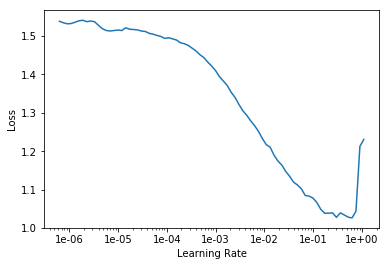

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.428986,0.302868,0.890298,03:04


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.273905,0.195139,0.929638,03:18


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.212497,0.173013,0.938374,04:35


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.177955,0.159329,0.943383,05:43
1,0.158616,0.156859,0.944321,05:50


In [0]:
learn.save('final')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.load('final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (211210 items)
x: TextList
xxbos xxmaj fed official says weak data caused by weather , should not slow taper,xxbos xxup us open : xxmaj stocks fall after xxmaj fed official hints at accelerated tapering,xxbos xxmaj fed risks falling ' behind the curve ' , xxmaj charles xxmaj plosser says,xxbos xxmaj fed 's xxmaj plosser : xxmaj nasty xxmaj weather xxmaj has xxmaj curbed xxmaj job xxmaj growth,xxbos xxmaj fed 's xxmaj plosser expects xxup us unemployment to fall to 6.2 % by the end of 2014
y: CategoryList
b,b,b,b,b
Path: data/mediabias;

Valid: LabelList (211209 items)
x: TextList
xxbos xxmaj edgar xxmaj wright xxmaj off of xxmaj marvel 's ' xxmaj ant - xxmaj man ',xxbos xxmaj mutant xxmaj muppets — x - xxmaj men : xxmaj days of xxmaj future xxmaj past xxmaj reviewed,xxbos xxmaj courtney xxmaj love is obsessed with the disappearance of xxmaj malaysia xxmaj airlines xxmaj flight ...,xxbos xxmaj deep - sea octopus observed brooding its 

In [0]:
text = "Spider-Man: Far From Home is saving the MCU by ignoring its continuity";
prediction = str(learn.predict(text)[0]);
if prediction == "e": print("Entertainment");
if prediction == "t": print("Technology");
if prediction == "m": print("Health");
if prediction == "b": print("Business");

Entertainment


In [0]:
learn.export()

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load("fine_tuned")

## ...And just for fun:

In [0]:
N_WORDS = 1000
N_SENTENCES = 1
TEXT = "Are you"
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Are you home the news of all time ? xxbos Jay z " Attacked By Solange " Video Of Beyonce Jay z 's Elevator Fight xxbos Obama Approves First Century Oil Amid Concerns of Twitter Users xxbos Sherlock : Big Winners And Rumors Time The Only One Is Xbox One And Out You xxbos Google Glass : One - third day only sale for only one day only xxbos Kim Kardashian Slams Kanye West 's Wedding Gown Together , Says IT Was Being ... xxbos Does Mars ' really be an example of planet ? NASA scientists say xxbos Miley Cyrus cancels concert in London after being hospitalised xxbos Apple Updates macbook Pro With Retina Display xxbos New Michael Jackson Album To Be Released In May xxbos Microsoft Office for ipad Unveiled by Microsoft xxbos Man 's Potato Salad Kickstarter Reaches $ 37000 xxbos Apple Slaps Seth Rogen , Scott Derrickson in Talks to Direct World War II xxbos Google Glass To Go On Sale In The UK For £ 1000 xxbos Selena Gomez Shares Sexy " Sexy " Photo xxbos Wall Street sees slight drop after Yell